In [1]:
import sys
sys.path.append('../..')  # Adjust the path to include the parent directory

import pandas as pd
import os
import numpy as np
import canopus
from plotnine import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from natsort import natsorted
import pytket.qasm
from qiskit import QuantumCircuit, qasm2


### Benchmark info

In [2]:
benchmark_table = pd.DataFrame(columns=["Program", "#Qubit", "#Can", "Depth2Q", "Cost"])

In [4]:
cx_cost_est = canopus.SynthCostEstimator('cx')
fnames = [os.path.join('../output/logical/tk2/', fname) for fname in natsorted(os.listdir('../output/logical/tk2/'))]
for fname in fnames:
    circ = pytket.qasm.circuit_from_qasm(fname)
    qc = canopus.utils.tket_to_qiskit(circ)

    benchmark_table = pd.concat([benchmark_table, pd.DataFrame({
        "Program": os.path.basename(fname).split('.')[0].split('_')[0],
        "#Qubit": qc.num_qubits,
        "#Can": qc.num_nonlocal_gates(),
        "Depth2Q": qc.depth(lambda instr: instr.operation.num_qubits > 1),
        "Cost": cx_cost_est.eval_circuit_duration(qc)
    }, index=[0])], ignore_index=True)

/var/folders/r5/1qhftv4d3_g432jmyr9vy6wc0000gn/T/ipykernel_51104/4289249078.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [5]:
benchmark_table


,Program,#Qubit,#Can,Depth2Q,Cost
0,bigadder,18,114,79,88.0
1,bv,19,18,18,18.0
2,gcm,13,377,376,510.0
3,ising,26,25,2,4.0
4,knn,25,72,50,62.0
5,multiplier,15,198,122,133.0
6,qec9xz,17,32,12,12.0
7,qft,18,153,33,66.0
8,qpeexact,16,127,43,86.0
9,qram,20,110,70,78.0


In [6]:
benchmark_table.to_latex('benchmark_table.tex', 
                         index=False, escape=False, 
                         float_format='%.1f', column_format='|l|r|r|r|r|')

### Detailed routing results

In [3]:

result_sabre_chain = pd.read_csv('../results/sabre-chain.csv')
result_canopus_chain = pd.read_csv('../results/canopus-chain.csv')
result_toqm_chain = pd.read_csv('../results/toqm-chain.csv')
result_bqskit_chain = pd.read_csv('../results/bqskit-chain.csv')

result_sabre_hhex = pd.read_csv('../results/sabre-hhex.csv')
result_canopus_hhex = pd.read_csv('../results/canopus-hhex.csv')
result_toqm_hhex = pd.read_csv('../results/toqm-hhex.csv')
result_bqskit_hhex = pd.read_csv('../results/bqskit-hhex.csv')

result_sabre_square = pd.read_csv('../results/sabre-square.csv')
result_canopus_square = pd.read_csv('../results/canopus-square.csv')
result_toqm_square = pd.read_csv('../results/toqm-square.csv')
result_bqskit_square = pd.read_csv('../results/bqskit-square.csv')

ISA_TYPES = ['cx', 'zzphase', 'sqisw', 'zzphase_', 'sqisw_', 'het']

In [4]:
result_sabre_chain

,program,num_qubits,cx,zzphase,sqisw,can_xx,can_xy,zzphase_,sqisw_,het
0,bigadder,18,2.818182,2.664773,2.650568,2.664773,1.718750,2.142992,2.147727,2.193182
1,bv,19,2.833333,2.833333,2.625000,2.833333,1.750000,2.259259,2.194444,2.291667
2,gcm,13,1.643137,1.313072,1.500000,1.299970,0.895472,1.100654,1.272549,1.115686
3,ising,26,1.000000,0.458333,0.750000,0.423185,0.423185,0.458333,0.750000,0.458333
4,knn,25,3.161290,2.903226,2.758065,2.903226,1.750000,2.266129,2.322581,2.330645
5,multiplier,15,2.330827,2.233083,2.278195,2.233083,1.488722,1.824561,1.819549,1.864662
6,qec9xz,17,5.333333,5.333333,4.375000,5.333333,2.916667,4.000000,3.750000,4.125000
7,qft,18,2.848485,1.954545,2.136364,1.645241,0.890980,1.527778,2.007576,1.575758
8,qpeexact,16,4.000000,3.319767,3.000000,3.132620,1.633272,2.488372,2.750000,2.578488
9,qram,20,2.935897,2.801282,2.644231,2.801282,1.717949,2.205128,2.192308,2.266026


In [5]:
def plot_bubbleheatmap_chart(topology, isa, title=None, savefig=False):

    if title is None:
        title = f'{topology.title()} topology - {isa.upper()} ISA'

    # 获取数据
    programs = result_sabre_chain['program']
    res_sabre = globals()[f'result_sabre_{topology}'][isa]
    res_toqm = globals()[f'result_toqm_{topology}'][isa]
    res_canopus = globals()[f'result_canopus_{topology}'][isa]
    res_bqskit = globals()[f'result_bqskit_{topology}'][isa]
    
    # 创建数据框
    df = pd.DataFrame({
        'Program': programs,
        'Sabre': res_sabre,
        'TOQM': res_toqm,
        'BQSKit': res_bqskit,
        'Canopus': res_canopus
    })

    # 转换为长格式
    df = df.melt(id_vars='Program', var_name='Compiler', value_name='Cost')

    # 设置排序：程序按原顺序，编译器按指定顺序（从上到下）
    df['Program'] = pd.Categorical(df['Program'], categories=programs, ordered=True)
    # 为了让Sabre在顶部，需要反转y轴的顺序
    df['Compiler'] = pd.Categorical(df['Compiler'], 
                                categories=['Canopus', 'BQSKit', 'TOQM', 'Sabre'], 
                                ordered=True)

    p = (ggplot(df, aes(x='Program', y='Compiler')) +
        
        # 添加背景矩阵网格 - 不使用任何aes映射
        geom_tile(alpha=0.03, color='lightgray', linetype='solid') +
        
        # 气泡点 - 在这里指定size和fill映射
        geom_point(aes(size='Cost', fill='Cost'), shape='o', alpha=0.8) +
        
        # 优美的配色方案
        scale_fill_gradientn(colors=[ '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'],
                             name=f'Overhead',) +

        # scale_fill_gradient2(high="#377EB8", low="#E41A1C", name='Cost') +
        
        # 调整气泡大小范围
        scale_size_continuous(range=(4, 18), name=f'Overhead') +
        
        # 标题和标签
        labs(title=title, x='', y='') +

        guides(size=False) +

        # 主题设置
        theme_minimal() +
        theme(
            # 旋转x轴标签
            axis_text_x=element_text(rotation=15, hjust=2, size=10),
            axis_text_y=element_text(size=11),

            text=element_text(family='Comic Sans MS'),
            
            # 图例设置
            legend_position='right',
            legend_title=element_text(size=11),
            legend_text=element_text(size=10),

            # legend_key_height=0.8,  # 相对高度（0~1，1表示与图形等高）
            # legend_margin=0,  # 去除边距
            legend_box_spacing=0.008,  # 减少图例与主图的间距
            # legend_key_width=20,  # 图例键的大小
            legend_key_height=150,  # 图例键的高度

    
            
            # 标题设置
            plot_title=element_text(size=12, face='bold'),
            axis_title=element_text(size=12),
            
            # 面板设置
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_rect(color='gray', fill='none'),
            
            # 图形大小
            figure_size=(8, 3)
        ) +
        
        # 确保显示所有刻度
        scale_x_discrete(expand=(0.02, 0.02)) +
        scale_y_discrete(expand=(0.02, 0.02))
    )

    if savefig:
        p.save(f'../figures/{topology}_{isa}.pdf')

    return p

In [6]:
plot_bubbleheatmap_chart('chain', 'cx', savefig=True);
plot_bubbleheatmap_chart('chain', 'zzphase', savefig=True);
plot_bubbleheatmap_chart('chain', 'sqisw', savefig=True);
plot_bubbleheatmap_chart('chain', 'zzphase_', savefig=True);
plot_bubbleheatmap_chart('chain', 'sqisw_', savefig=True);
plot_bubbleheatmap_chart('chain', 'het', savefig=True);

/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/chain_cx.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/chain_zzphase.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/chain_sqisw.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/chain_zzphase_.pdf
/Users/anan/mi

In [7]:
plot_bubbleheatmap_chart('hhex', 'cx', savefig=True);
plot_bubbleheatmap_chart('hhex', 'zzphase', savefig=True);
plot_bubbleheatmap_chart('hhex', 'sqisw', savefig=True);
plot_bubbleheatmap_chart('hhex', 'zzphase_', savefig=True);
plot_bubbleheatmap_chart('hhex', 'sqisw_', savefig=True);
plot_bubbleheatmap_chart('hhex', 'het', savefig=True);

/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/hhex_cx.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/hhex_zzphase.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/hhex_sqisw.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/hhex_zzphase_.pdf
/Users/anan/minico

In [8]:
plot_bubbleheatmap_chart('square', 'cx', savefig=True);
plot_bubbleheatmap_chart('square', 'zzphase', savefig=True);
plot_bubbleheatmap_chart('square', 'sqisw', savefig=True);
plot_bubbleheatmap_chart('square', 'zzphase_', savefig=True);
plot_bubbleheatmap_chart('square', 'sqisw_', savefig=True);
plot_bubbleheatmap_chart('square', 'het', savefig=True);

/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/square_cx.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/square_zzphase.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/square_sqisw.pdf
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../figures/square_zzphase_.pdf
/Users/ana

/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 3 in image.
/Users/anan/miniconda3/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: chain_zzphase_.pdf


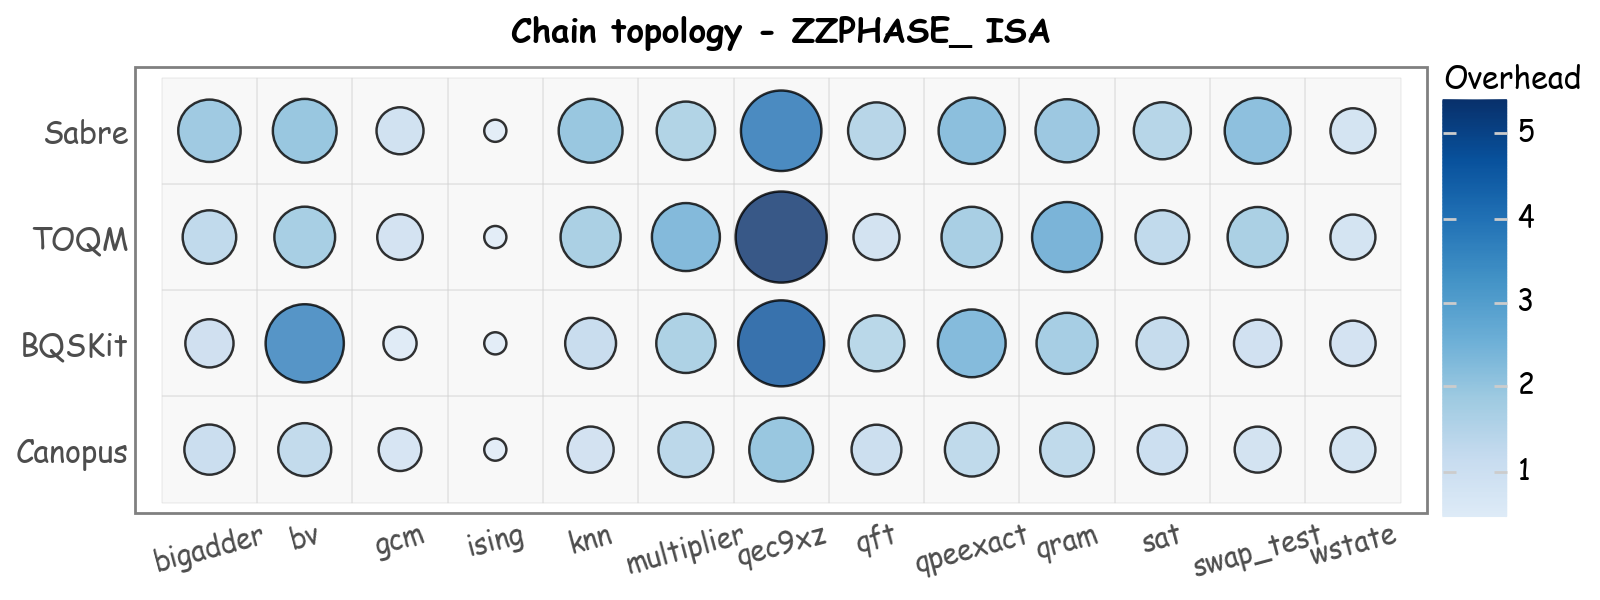

In [39]:
plot_bubbleheatmap_chart('chain', 'zzphase_', savefig=True)

### Average routing results

In [11]:
def filter_vf2layout(result):
    return result[~(result['cx'] <= 1)]

result_sabre_chain = filter_vf2layout(pd.read_csv('../results/sabre-chain.csv'))
result_canopus_chain = filter_vf2layout(pd.read_csv('../results/canopus-chain.csv'))
result_toqm_chain = filter_vf2layout(pd.read_csv('../results/toqm-chain.csv'))
result_bqskit_chain = filter_vf2layout(pd.read_csv('../results/bqskit-chain.csv'))

result_sabre_hhex = filter_vf2layout(pd.read_csv('../results/sabre-hhex.csv'))
result_canopus_hhex = filter_vf2layout(pd.read_csv('../results/canopus-hhex.csv'))
result_toqm_hhex = filter_vf2layout(pd.read_csv('../results/toqm-hhex.csv'))
result_bqskit_hhex = filter_vf2layout(pd.read_csv('../results/bqskit-hhex.csv'))

result_sabre_square = filter_vf2layout(pd.read_csv('../results/sabre-square.csv'))
result_canopus_square = filter_vf2layout(pd.read_csv('../results/canopus-square.csv'))
result_toqm_square = filter_vf2layout(pd.read_csv('../results/toqm-square.csv'))
result_bqskit_square = filter_vf2layout(pd.read_csv('../results/bqskit-square.csv'))

ISA_TYPES = ['cx', 'zzphase', 'sqisw', 'zzphase_', 'sqisw_', 'het']

In [12]:
result = pd.DataFrame(columns=[
    'Topology', 'Sabre(cx)', 'TOQM(cx)', 'BQSKit(cx)', 'Canopus(cx)',
    'Sabre(zzphase)', 'TOQM(zzphase)', 'BQSKit(zzphase)', 'Canopus(zzphase)',
    'Sabre(sqisw)', 'TOQM(sqisw)', 'BQSKit(sqisw)', 'Canopus(sqisw)',
    'Sabre(zzphase_)', 'TOQM(zzphase_)',
    'BQSKit(zzphase_)', 'Canopus(zzphase_)',
    'Sabre(sqisw_)', 'TOQM(sqisw_)',
    'BQSKit(sqisw_)', 'Canopus(sqisw_)',
    'Sabre(het)', 'TOQM(het)',
    'BQSKit(het)', 'Canopus(het)'
])

result = pd.DataFrame({
    'Topology': ['Chain', 'HHex', 'Square'],
    'Sabre (cx)': [gmean(result_sabre_chain['cx']), gmean(result_sabre_hhex['cx']), gmean(result_sabre_square['cx'])],
    'TOQM (cx)': [gmean(result_toqm_chain['cx']), gmean(result_toqm_hhex['cx']), gmean(result_toqm_square['cx'])],
    'BQSKit (cx)': [gmean(result_bqskit_chain['cx']), gmean(result_bqskit_hhex['cx']), gmean(result_bqskit_square['cx'])],
    'Canopus (cx)': [gmean(result_canopus_chain['cx']), gmean(result_canopus_hhex['cx']), gmean(result_canopus_square['cx'])],

    'Sabre (zzphase)': [gmean(result_sabre_chain['zzphase']), gmean(result_sabre_hhex['zzphase']), gmean(result_sabre_square['zzphase'])],
    'TOQM (zzphase)': [gmean(result_toqm_chain['zzphase']), gmean(result_toqm_hhex['zzphase']), gmean(result_toqm_square['zzphase'])],
    'BQSKit (zzphase)': [gmean(result_bqskit_chain['zzphase']), gmean(result_bqskit_hhex['zzphase']), gmean(result_bqskit_square['zzphase'])],
    'Canopus (zzphase)': [gmean(result_canopus_chain['zzphase']), gmean(result_canopus_hhex['zzphase']), gmean(result_canopus_square['zzphase'])],
    
    'Sabre (sqisw)': [gmean(result_sabre_chain['sqisw']), gmean(result_sabre_hhex['sqisw']), gmean(result_sabre_square['sqisw'])],
    'TOQM (sqisw)': [gmean(result_toqm_chain['sqisw']), gmean(result_toqm_hhex['sqisw']), gmean(result_toqm_square['sqisw'])],
    'BQSKit (sqisw)': [gmean(result_bqskit_chain['sqisw']), gmean(result_bqskit_hhex['sqisw']), gmean(result_bqskit_square['sqisw'])],
    'Canopus (sqisw)': [gmean(result_canopus_chain['sqisw']), gmean(result_canopus_hhex['sqisw']), gmean(result_canopus_square['sqisw'])],

    'Sabre (zzphase_)': [gmean(result_sabre_chain['zzphase_']), gmean(result_sabre_hhex['zzphase_']), gmean(result_sabre_square['zzphase_'])],
    'TOQM (zzphase_)': [gmean(result_toqm_chain['zzphase_']), gmean(result_toqm_hhex['zzphase_']), gmean(result_toqm_square['zzphase_'])],
    'BQSKit (zzphase_)': [gmean(result_bqskit_chain['zzphase_']), gmean(result_bqskit_hhex['zzphase_']), gmean(result_bqskit_square['zzphase_'])],
    'Canopus (zzphase_)': [gmean(result_canopus_chain['zzphase_']), gmean(result_canopus_hhex['zzphase_']), gmean(result_canopus_square['zzphase_'])],

    'Sabre (sqisw_)': [gmean(result_sabre_chain['sqisw_']), gmean(result_sabre_hhex['sqisw_']), gmean(result_sabre_square['sqisw_'])],
    'TOQM (sqisw_)': [gmean(result_toqm_chain['sqisw_']), gmean(result_toqm_hhex['sqisw_']), gmean(result_toqm_square['sqisw_'])],
    'BQSKit (sqisw_)': [gmean(result_bqskit_chain['sqisw_']), gmean(result_bqskit_hhex['sqisw_']), gmean(result_bqskit_square['sqisw_'])],
    'Canopus (sqisw_)': [gmean(result_canopus_chain['sqisw_']), gmean(result_canopus_hhex['sqisw_']), gmean(result_canopus_square['sqisw_'])],

    'Sabre (het)': [gmean(result_sabre_chain['het']), gmean(result_sabre_hhex['het']), gmean(result_sabre_square['het'])],
    'TOQM (het)': [gmean(result_toqm_chain['het']), gmean(result_toqm_hhex['het']), gmean(result_toqm_square['het'])],
    'BQSKit (het)': [gmean(result_bqskit_chain['het']), gmean(result_bqskit_hhex['het']), gmean(result_bqskit_square['het'])],
    'Canopus (het)': [gmean(result_canopus_chain['het']), gmean(result_canopus_hhex['het']), gmean(result_canopus_square['het'])]
})



In [13]:
part1_columns = ['Topology'] + [f'{compiler} (cx)' for compiler in ['Sabre', 'TOQM', 'BQSKit', 'Canopus']] + [f'{compiler} (zzphase)' for compiler in ['Sabre', 'TOQM', 'BQSKit', 'Canopus']]
part2_columns = ['Topology'] + [f'{compiler} (sqisw)' for compiler in ['Sabre', 'TOQM', 'BQSKit', 'Canopus']] + [f'{compiler} (zzphase_)' for compiler in ['Sabre', 'TOQM', 'BQSKit', 'Canopus']]
part3_columns = ['Topology'] + [f'{compiler} (sqisw_)' for compiler in ['Sabre', 'TOQM', 'BQSKit', 'Canopus']] + [f'{compiler} (het)' for compiler in ['Sabre', 'TOQM', 'BQSKit', 'Canopus']]


result[part1_columns].to_latex('result_table_part1.tex', 
                index=False, escape=False, 
                float_format='%.2f', column_format='|l|' + 'r|' * (len(result.columns) - 1))
result[part2_columns].to_latex('result_table_part2.tex', 
                index=False, escape=False, 
                float_format='%.2f', column_format='|l|' + 'r|' * (len(result.columns) - 1))
result[part3_columns].to_latex('result_table_part3.tex', 
                index=False, escape=False, 
                float_format='%.2f', column_format='|l|' + 'r|' * (len(result.columns) - 1))

